In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/My\ Projects/yolo_custom_training

Mounted at /content/drive
/content/drive/My Drive/My Projects/yolo_custom_training


## Install YOLOv8

In [2]:
# Pip install method (recommended)
!pip install ultralytics==8.0.20

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.20 🚀 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.3/78.2 GB disk)


### Inference

1. On Image

In [3]:
import cv2
import matplotlib.pyplot as plt
from image_segmenter import ImageSegmenter
from ultralytics import YOLO

Ultralytics YOLOv8.0.20 🚀 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


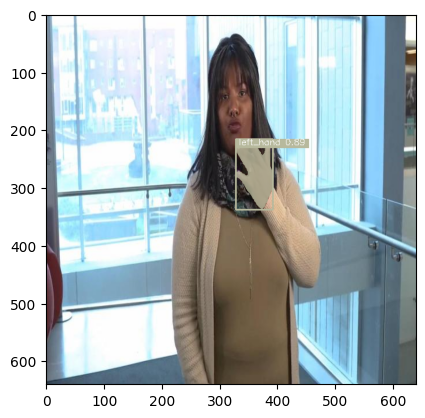

In [5]:
img_path = "assets/images/img_1.jpg"
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

seg_model = ImageSegmenter(model_type="yolov8m-seg-custom")
seg_model.is_show_segmentation = True
prediction,_ = seg_model.predict(image)

plt.imshow(prediction)
plt.show()

2. On Video

In [ ]:
seg_model = ImageSegmenter(model_type="yolov8m-seg-custom")
seg_model.is_show_segmentation = True
seg_model.is_show_bounding_boxes = False

vid_path = "assets/videos/Sign_language_interpreter_vid_4.mp4"
cap = cv2.VideoCapture(vid_path)

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create VideoWriter object
output_path = "output/video_with_segmentation_3.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        prediction, _ = seg_model.predict(frame)
        prediction = cv2.cvtColor(prediction, cv2.COLOR_RGB2BGR)

        # Save frame with segmentation overlay
        out.write(prediction)

        # does not work in goole colab
        # cv2.imshow("Segmentation", prediction)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()

### Gradio GUI App

In [ ]:
!pip install gradio

In [ ]:
from ultralytics import YOLO
import cv2
import gradio as gr
import numpy as np
import os
import torch
from image_segmenter import ImageSegmenter

# params
CANCEL_PROCESSING = False

img_seg = ImageSegmenter(model_type="yolov8m-seg-custom")

def resize(image):
    """
    resize the input nd array
    """
    h, w = image.shape[:2]
    if h > w:
        return cv2.resize(image, (480, 640))
    else:
        return cv2.resize(image, (640, 480))

def process_image(image):
    image = resize(image)
    prediction, _ = img_seg.predict(image)
    return prediction


def process_video(vid_path=None):
    vid_cap = cv2.VideoCapture(vid_path)
    while vid_cap.isOpened():
        ret, frame = vid_cap.read()
        if ret:
            print("Making frame predictions ....")
            frame = resize(frame)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            prediction, _ = img_seg.predict(frame)
            yield prediction

    return None

def update_segmentation_options(options):
    img_seg.is_show_bounding_boxes = True if 'Show Boundary Box' in options else False
    img_seg.is_show_segmentation = True if 'Show Segmentation Region' in options else False
    img_seg.is_show_segmentation_boundary = True if 'Show Segmentation Boundary' in options else False

def update_confidence_threshold(thres_val):
    img_seg.confidence_threshold = thres_val/100

def model_selector(model_type):

    if "Small - Better performance and less accuracy" == model_type:
        yolo_model = "yolov8s_seg_custom"
    elif "Medium - Balanced performance and accuracy" == model_type:
        yolo_model = "yolov8m-seg-custom"
    elif "Large - Slow performance and high accuracy" == model_type:
        yolo_model = "yolov8m-seg-custom"
    else:
        yolo_model = "yolov8m-seg-custom"

    img_seg = ImageSegmenter(model_type=yolo_model)

def cancel():
    CANCEL_PROCESSING = True

if __name__ == "__main__":

    # gradio gui app
    with gr.Blocks() as my_app:

        # title
        gr.Markdown("<h1><center>Hand detection and segmentation</center></h1>")

        # tabs
        with gr.Tab("Image"):
            with gr.Row():
                with gr.Column(scale=1):
                    img_input = gr.Image()
                    model_type_img = gr.Dropdown(
                        ["Small - Better performance and less accuracy",
                         "Medium - Balanced performance and accuracy",
                         "Large - Slow performance and high accuracy"],
                        label="Model Type", value="Medium - Balanced performance and accuracy",
                        info="Select the inference model before running predictions!")
                    options_checkbox_img = gr.CheckboxGroup(["Show Boundary Box", "Show Segmentation Region"], label="Options")
                    conf_thres_img = gr.Slider(1, 100, value=60, label="Confidence Threshold", info="Choose the threshold above which objects should be detected")
                    submit_btn_img = gr.Button(value="Predict")

                with gr.Column(scale=2):
                    with gr.Row():
                        img_output = gr.Image(height=300, label="Segmentation")

            # gr.Markdown("## Sample Images")
            # gr.Examples(
            #     examples=[os.path.join(os.path.dirname(__file__), "assets/images/img_1.jpg"),
            #               os.path.join(os.path.dirname(__file__), "assets/images/img_1.jpg")],
            #     inputs=img_input,
            #     outputs=img_output,
            #     fn=process_image,
            #     cache_examples=True,
            # )

        with gr.Tab("Video"):
            with gr.Row():
                with gr.Column(scale=1):
                    vid_input = gr.Video()
                    model_type_vid = gr.Dropdown(
                        ["Small - Better performance and less accuracy",
                         "Medium - Balanced performance and accuracy",
                         "Large - Slow performance and high accuracy"],
                        label="Model Type", value="Medium - Balanced performance and accuracy",
                        info="Select the inference model before running predictions!")

                    options_checkbox_vid = gr.CheckboxGroup(["Show Boundary Box", "Show Segmentation Region"], label="Options")
                    conf_thres_vid = gr.Slider(1, 100, value=60, label="Confidence Threshold", info="Choose the threshold above which objects should be detected")
                    with gr.Row():
                        cancel_btn = gr.Button(value="Cancel")
                        submit_btn_vid = gr.Button(value="Predict")

                with gr.Column(scale=2):
                    with gr.Row():
                        vid_output = gr.Image(height=300, label="Segmentation")

            # gr.Markdown("## Sample Videos")
            # gr.Examples(
            #     examples=[os.path.join(os.path.dirname(__file__), "assets/videos/vid_1.mp4"),
            #               os.path.join(os.path.dirname(__file__), "assets/videos/vid_2.mp4"),],
            #     inputs=vid_input,
            #     # outputs=vid_output,
            #     # fn=vid_segmenation,
            # )


        # image tab logic
        submit_btn_img.click(process_image, inputs=img_input, outputs=img_output)
        options_checkbox_img.change(update_segmentation_options, options_checkbox_img, [])
        conf_thres_img.change(update_confidence_threshold, conf_thres_img, [])
        model_type_img.change(model_selector, model_type_img, [])

        # video tab logic
        submit_btn_vid.click(process_video, inputs=vid_input, outputs=vid_output)
        model_type_vid.change(model_selector, model_type_vid, [])
        cancel_btn.click(cancel, inputs=[], outputs=[])
        options_checkbox_vid.change(update_segmentation_options, options_checkbox_vid, [])
        conf_thres_vid.change(update_confidence_threshold, conf_thres_vid, [])


    my_app.queue(concurrency_count=5, max_size=20).launch(debug=True)